# Load Model

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torchvision import transforms
from torchvision.io import read_image
import torch.nn.functional as F
import os


plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)

In [4]:
import torchvision
model = torchvision.models.resnet18(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Load Image

In [10]:
# Download an example image from the pytorch website
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


filename = "./data/dog.jpg"
if (not os.path.exists("./data/dog.jpg")):
    import urllib
    url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", filename)
    try: urllib.URLopener().retrieve(url, filename)
    except: urllib.request.urlretrieve(url, filename)

# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
image = Image.open(filename)
input_image = preprocess(image)

# Read the categories
with open("./data/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [63]:
# load other images
# https://github.com/EliSchwartz/imagenet-sample-images
    
def load_img(url):
    filename = "./data/" + url.split("/")[-1]
    print(filename)
    if (not os.path.exists(filename)):
        import urllib
        try: urllib.URLopener().retrieve(url, filename)
        except: urllib.request.urlretrieve(url, filename)
    image = Image.open(filename)
    input_image = preprocess(image)
    return image, input_image

git_path = "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/"

examples = [
    "n01443537_goldfish.JPEG",
    "n01532829_house_finch.JPEG",
    "n01491361_tiger_shark.JPEG",
    "n01622779_great_grey_owl.JPEG",
    "n01693334_green_lizard.JPEG",
    "n03662601_lifeboat.JPEG",
    "n03666591_lighter.JPEG",
    "n03691459_loudspeaker.JPEG",
    "n01742172_boa_constrictor.JPEG",
    "n01744401_rock_python.JPEG",
    "n01773797_garden_spider.JPEG",
]

other_images = {url: load_img(git_path + url) for url in examples}

./data/n01443537_goldfish.JPEG
./data/n01532829_house_finch.JPEG
./data/n01491361_tiger_shark.JPEG
./data/n01622779_great_grey_owl.JPEG
./data/n01693334_green_lizard.JPEG
./data/n03662601_lifeboat.JPEG
./data/n03666591_lighter.JPEG
./data/n03691459_loudspeaker.JPEG
./data/n01742172_boa_constrictor.JPEG
./data/n01744401_rock_python.JPEG
./data/n01773797_garden_spider.JPEG


In [12]:
len(categories)

1000

# LIME
Following tutorial here:
https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

## LIME: Prep 1 (Example only)

In [143]:
input_batch = input_image.unsqueeze(0) # create a mini-batch as expected by the model
label = torch.LongTensor([categories.index("Samoyed")])

In [40]:
model.eval()
logits = model(input_batch)

In [65]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, categories[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.83719707, 258, 'Samoyed'),
 (0.060999483, 270, 'white wolf'),
 (0.039010566, 261, 'keeshond'),
 (0.02333681, 259, 'Pomeranian'),
 (0.013027882, 279, 'Arctic fox'))

In [17]:
def get_topk_pred(input_image, n=5):
    input_batch = input_image.unsqueeze(0)
    model.eval()
    logits = model(input_batch)
    probs = F.softmax(logits, dim=1)
    probsk = probs.topk(5)
    topk = tuple((p,c, categories[c]) for p, c in zip(probsk[0][0].detach().numpy(), probsk[1][0].detach().numpy()))
    return topk

In [65]:
for x in other_images:
    print(x)
    print(get_topk_pred(other_images[x][1]))
    print()

n01443537_goldfish.JPEG
((0.99933654, 1, 'goldfish'), (0.00032708317, 29, 'axolotl'), (0.00020347965, 0, 'tench'), (7.1696624e-05, 397, 'puffer'), (1.7897988e-05, 392, 'rock beauty'))

n01532829_house_finch.JPEG
((0.9996082, 12, 'house finch'), (0.00012743162, 13, 'junco'), (0.00012097381, 11, 'goldfinch'), (9.754117e-05, 10, 'brambling'), (1.3009172e-05, 86, 'partridge'))

n01491361_tiger_shark.JPEG
((0.98051274, 3, 'tiger shark'), (0.01920419, 2, 'great white shark'), (0.00024050837, 4, 'hammerhead'), (3.0223337e-05, 394, 'sturgeon'), (7.3704637e-06, 6, 'stingray'))

n01622779_great_grey_owl.JPEG
((0.99999857, 24, 'great grey owl'), (7.557964e-07, 330, 'wood rabbit'), (2.567258e-07, 331, 'hare'), (7.351187e-08, 322, 'ringlet'), (4.6795755e-08, 21, 'kite'))

n01693334_green_lizard.JPEG
((0.49509487, 40, 'American chameleon'), (0.4931054, 46, 'green lizard'), (0.0037141198, 44, 'alligator lizard'), (0.0022230602, 42, 'agama'), (0.0011226484, 38, 'banded gecko'))

n03662601_lifeboat.JPE

## LIME: Prep 2

In [66]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [67]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [68]:
test_pred = batch_predict([pill_transf(image)])
test_pred.squeeze().argmax()

258

## LIME image

In [69]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [77]:
def get_lime_explainer(image, top_label=0, num_features=5):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(pill_transf(image)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=num_features, hide_rest=False)
    img_boundry1 = mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry1)
    plt.show()
    return explanation

def plot_boundaries(explanation, top_label=0, num_features=[10, 50, 100]):
    for x in num_features:
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, 
                                                num_features=x, hide_rest=False)
        img_boundry2 = mark_boundaries(temp/255.0, mask)
        plt.imshow(img_boundry2)
        plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

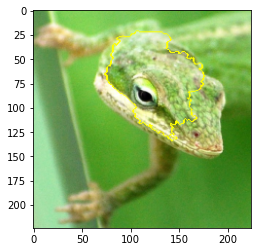

In [80]:
explanation_lizard = get_lime_explainer(
    other_images['n01693334_green_lizard.JPEG'][0], top_label=0, num_features=5
)

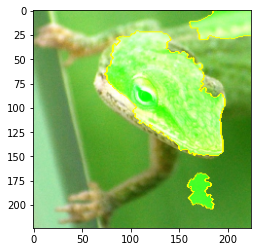

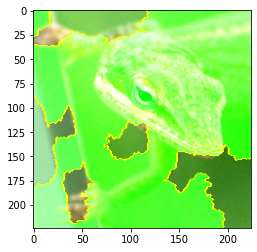

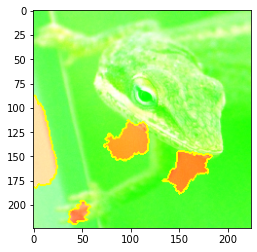

In [92]:
plot_boundaries(explanation_lizard, top_label=0, num_features=[10, 30, 100])

  0%|          | 0/1000 [00:00<?, ?it/s]

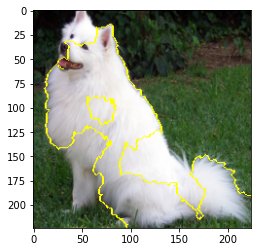

In [82]:
explanation_dog = get_lime_explainer(
    image, top_label=0, num_features=5
)

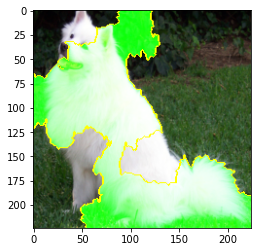

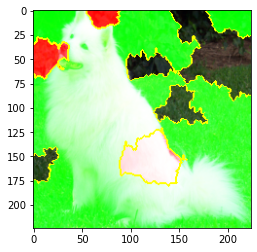

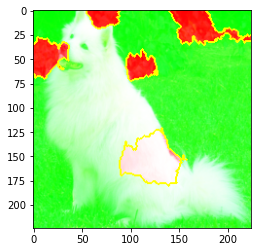

In [91]:
plot_boundaries(explanation_dog, top_label=0, num_features=[10, 30, 100])